In [1]:
import os 
os.chdir("/workspace/apai4798/uvi-social-interaction/CAFE_codebase")

In [2]:
import argparse
import pickle

import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms

from models.models import GADTR

In [3]:
parser = argparse.ArgumentParser(description='Group Activity Detection train code', add_help=False)

# Dataset specification
parser.add_argument('--dataset', default='cafe', type=str, help='dataset name')
parser.add_argument('--val_mode', action='store_true')
parser.add_argument('--split', default='place', type=str, help='dataset split. place or view')
parser.add_argument('--data_path', default='../Dataset/', type=str, help='data path')
parser.add_argument('--image_width', default=1280, type=int, help='Image width to resize')
parser.add_argument('--image_height', default=720, type=int, help='Image height to resize')
parser.add_argument('--random_sampling', action='store_true', help='random sampling strategy')
parser.add_argument('--num_frame', default=5, type=int, help='number of frames for each clip')
parser.add_argument('--num_class', default=6, type=int, help='number of activity classes')

# Backbone parameters
parser.add_argument('--backbone', default='resnet18', type=str, help='feature extraction backbone')
parser.add_argument('--dilation', action='store_true', help='use dilation or not')
parser.add_argument('--frozen_batch_norm', action='store_true', help='use frozen batch normalization')
parser.add_argument('--hidden_dim', default=256, type=int, help='transformer channel dimension')

# RoI Align parameters
parser.add_argument('--num_boxes', default=14, type=int, help='maximum number of actors')
parser.add_argument('--crop_size', default=5, type=int, help='roi align crop size')

# Group Transformer
parser.add_argument('--gar_nheads', default=4, type=int, help='number of heads')
parser.add_argument('--gar_enc_layers', default=6, type=int, help='number of group transformer layers')
parser.add_argument('--gar_ffn_dim', default=512, type=int, help='feed forward network dimension')
parser.add_argument('--position_embedding', default='sine', type=str, help='various position encoding')
parser.add_argument('--num_group_tokens', default=12, type=int, help='number of group tokens')
parser.add_argument('--aux_loss', action='store_true')
parser.add_argument('--group_threshold', default=0.5, type=float, help='post processing threshold')
parser.add_argument('--distance_threshold', default=0.2, type=float, help='distance mask threshold')

# Loss option
parser.add_argument('--temperature', default=0.2, type=float, help='consistency loss temperature')

# Loss coefficients (Individual)
parser.add_argument('--ce_loss_coef', default=1, type=float)
parser.add_argument('--eos_coef', default=1, type=float,
                    help="Relative classification weight of the no-object class")

# Loss coefficients (Group)
parser.add_argument('--group_eos_coef', default=1, type=float)
parser.add_argument('--group_ce_loss_coef', default=1, type=float)
parser.add_argument('--group_code_loss_coef', default=5, type=float)
parser.add_argument('--consistency_loss_coef', default=2, type=float)

# Matcher (Group)
parser.add_argument('--set_cost_group_class', default=1, type=float,
                    help="Class coefficient in the matching cost")
parser.add_argument('--set_cost_membership', default=1, type=float,
                    help="Membership coefficient in the matching cost")

# Training parameters
parser.add_argument('--random_seed', default=1, type=int, help='random seed for reproduction')
parser.add_argument('--epochs', default=30, type=int, help='Max epochs')
parser.add_argument('--test_freq', default=1, type=int, help='print frequency')
parser.add_argument('--batch', default=16, type=int, help='Batch size')
parser.add_argument('--test_batch', default=16, type=int, help='Test batch size')
parser.add_argument('--lr', default=1e-5, type=float, help='Initial learning rate')
parser.add_argument('--max_lr', default=1e-4, type=float, help='Max learning rate')
parser.add_argument('--lr_step', default=4, type=int, help='step size for learning rate scheduler')
parser.add_argument('--lr_step_down', default=25, type=int, help='step down size (cyclic) for learning rate scheduler')
parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight decay')
parser.add_argument('--drop_rate', default=0.1, type=float, help='Dropout rate')
parser.add_argument('--gradient_clipping', action='store_true', help='use gradient clipping')
parser.add_argument('--max_norm', default=1.0, type=float, help='gradient clipping max norm')

# GPU
parser.add_argument('--device', default="0, 1", type=str, help='GPU device')
parser.add_argument('--distributed', action='store_true')

# Load model
parser.add_argument('--load_model', action='store_true', help='load model')
parser.add_argument('--model_path', default="", type=str, help='pretrained model path')

# Visualization
parser.add_argument('--result_path', default="./outputs/")

# Evaluation
parser.add_argument('--groundtruth', default='./evaluation/gt_tracks_24.txt', type=argparse.FileType("r"))
parser.add_argument('--labelmap', default='./label_map/group_action_list.pbtxt', type=argparse.FileType("r"))
parser.add_argument('--giou_thresh', default=1.0, type=float)
parser.add_argument('--eval_type', default="gt_base", type=str, help='gt_based or detection_based')

# --image_width 3840 --image_height 2160
args = parser.parse_args("--data_path Dataset/ --split 'place' --model_path cafe_place.pth --image_width 3840 --image_height 2160".split(' '))

transform = transforms.Compose([
    transforms.Resize((args.image_height, args.image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
args

Namespace(aux_loss=False, backbone='resnet18', batch=16, ce_loss_coef=1, consistency_loss_coef=2, crop_size=5, data_path='Dataset/', dataset='cafe', device='0, 1', dilation=False, distance_threshold=0.2, distributed=False, drop_rate=0.1, eos_coef=1, epochs=30, eval_type='gt_base', frozen_batch_norm=False, gar_enc_layers=6, gar_ffn_dim=512, gar_nheads=4, giou_thresh=1.0, gradient_clipping=False, groundtruth=<_io.TextIOWrapper name='./evaluation/gt_tracks_24.txt' mode='r' encoding='UTF-8'>, group_ce_loss_coef=1, group_code_loss_coef=5, group_eos_coef=1, group_threshold=0.5, hidden_dim=256, image_height=2160, image_width=3840, labelmap=<_io.TextIOWrapper name='./label_map/group_action_list.pbtxt' mode='r' encoding='UTF-8'>, load_model=False, lr=1e-05, lr_step=4, lr_step_down=25, max_lr=0.0001, max_norm=1.0, model_path='cafe_place.pth', num_boxes=14, num_class=6, num_frame=5, num_group_tokens=12, position_embedding='sine', random_sampling=False, random_seed=1, result_path='./outputs/', set

In [5]:
model = GADTR(args)

pretrained_dict = torch.load(args.model_path)['state_dict']
new_state_dict = model.state_dict()
for k, v in pretrained_dict.items():
    if k in new_state_dict:
        new_state_dict.update({k:v})

model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [6]:
with open("./Dataset/belcher/3007/track.pkl", "rb") as file:
    tracks = pickle.load(file)
imgs = sorted([i for i in os.listdir("./Dataset/belcher/3007/") if i.endswith(".jpg")])
idx = np.linspace(0, len(imgs)-1, num=5, dtype=int)
imgs = [imgs[i] for i in idx]

images = []
for imname in imgs:
    images.append(transform(Image.open(os.path.join("./Dataset/belcher/3007/", imname))))
images = torch.stack(images)
    

In [7]:
images.shape

torch.Size([5, 3, 2160, 3840])

In [8]:
idx

array([0, 2, 4, 6, 9])

In [47]:
boxes = [j[1] for j in [list(tracks.items())[i] for i in idx]]
boxes = [[t[i][1:] for i in range(len(t)) if i != 10] for t in boxes]

In [48]:
boxes = torch.tensor(boxes)

In [49]:
boxes.unsqueeze(0).shape

torch.Size([1, 5, 14, 4])

In [50]:
mask = np.zeros(14)
mask = torch.tensor(mask.astype(bool)).unsqueeze(0)

In [51]:
model.eval().cuda()
with torch.no_grad():
    output = model(images.unsqueeze(0).cuda(), boxes.unsqueeze(0).cuda(), mask.cuda())

In [52]:
output

{'pred_actions': tensor([[[-1.4998,  2.6622,  3.1059, -0.5998, -0.0548,  1.2764,  1.2166],
          [-0.8510,  3.0094,  3.2207,  0.2066,  0.7191,  0.4281,  1.0320],
          [-1.8495,  2.6049,  3.2510, -0.6736, -0.5568,  0.9017,  1.7437],
          [-2.4374,  2.8858,  2.7908, -1.5722, -0.2857,  0.4653,  1.2307],
          [-2.5584,  3.6381,  2.3001, -1.5407,  1.2246,  0.2927,  1.6155],
          [-1.9656,  2.7619,  1.1101, -1.8180,  0.8663,  0.6114,  1.9352],
          [-2.0301,  1.4805,  2.0882, -1.2526,  0.1031,  0.7032,  0.6494],
          [-2.7731,  3.4669,  1.5018, -1.9413,  1.5986, -0.2435,  0.7749],
          [-2.6219,  3.4305,  2.0698, -2.2417,  2.4541,  0.4766,  0.3261],
          [-0.2825,  3.5756,  1.7012, -1.3684,  1.7250, -1.0109,  1.5874],
          [-1.6198,  3.7986,  0.1036, -2.0274,  2.1470, -0.4475, -1.0182],
          [-1.4996,  3.7114,  0.8408, -2.5780,  1.6297,  0.4126,  0.2094],
          [-1.5589,  5.0178,  2.3145, -1.8806,  2.5496, -1.4812,  1.9236],
         

In [59]:
import torch.nn.functional as F

pred_group_actions = output['pred_activities'][0]
pred_group_actions = F.softmax(pred_group_actions, dim=1)
members = output['membership'][0]

pred_membership = torch.argmax(members.transpose(0, 1), dim=1).detach().cpu()
keep_membership = members.transpose(0, 1).max(-1).values > args.group_threshold
pred_group_action = torch.argmax(pred_group_actions, dim=1).detach().cpu()

In [65]:
pred_membership
len(pred_group_action)

12

In [67]:
imgs = sorted([i for i in os.listdir("./Dataset/belcher/3007/") if i.endswith(".jpg")])
out_img_name = imgs[6]
out_track = tracks[3006]
out_bbox = [out_track[i] for i in range(len(out_track)) if i != 10]

out_img = cv2.imread(os.path.join("./Dataset/belcher/3007/", out_img_name))
h, w, _ = out_img.shape
font = cv2.FONT_HERSHEY_SIMPLEX 

for i, box in enumerate(out_bbox):
    cv2.rectangle(out_img, (int(box[1]*w), int(box[2]*h)), (int(box[3]*w), int(box[4]*h)), (0, 0, 255), 2)
    pos = np.array((int(box[1]*w), int(box[2]*h))) - np.array((0, 20))


    text = f"group:{pred_membership[i]} action:{pred_group_action[pred_membership[i]]}"
    cv2.putText(out_img, text, pos, font, 1, (0, 0, 255), 2)

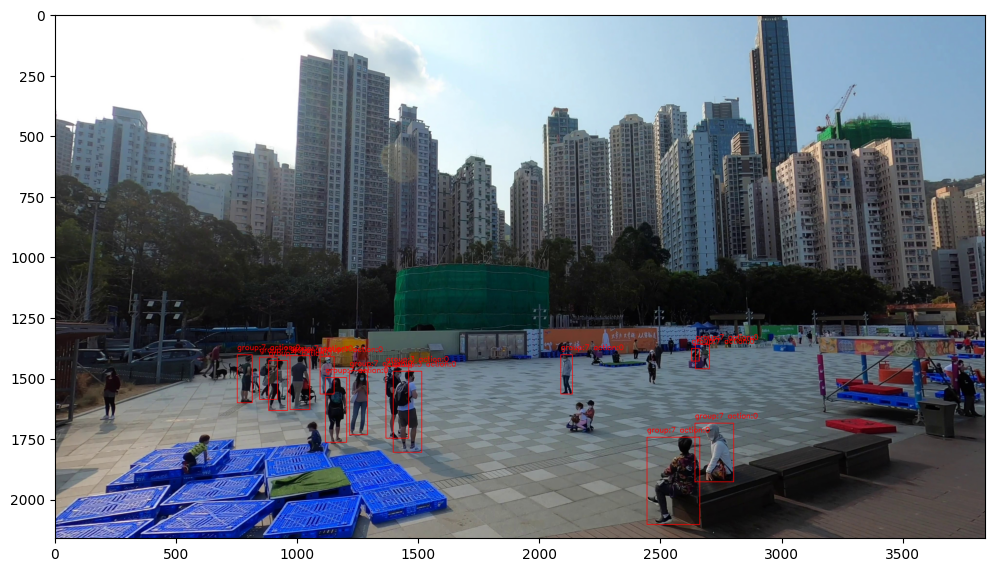

In [68]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(12, 10))
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

In [69]:
cv2.imwrite("outputs/exp1.jpg", out_img)

True